In [1]:
from pathlib import Path
import string

import numpy as np
import scipy as sci
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

import gm

from glacierData import glacierData
from utils import hist2, weighted_quantile

# todo: add total iterations to tqdm

In [2]:
gd = glacierData()
gd.calc_response_time()
gd.calc_diseq()
d = gd.rgi

/Users/drotto/src/USGS/glacier-diseq/ak_diseq/thickness.py:9: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  f_geom = pickle.load(f)


[0.00851064 0.01420213 0.01989362 0.02558511 0.0312766  0.03696809
 0.04265957 0.04835106 0.05404255 0.05973404 0.06542553 0.07111702
 0.07680851 0.0825     0.08819149 0.09388298 0.09957447 0.10526596
 0.11095745 0.11664894 0.12234043 0.12803191 0.1337234  0.13941489
 0.14510638 0.15079787 0.15648936 0.16218085 0.16787234 0.17356383
 0.17925532 0.18494681 0.1906383  0.19632979 0.20202128 0.20771277
 0.21340426 0.21909574 0.22478723 0.23047872 0.23617021 0.2418617
 0.24755319 0.25324468 0.25893617 0.26462766 0.27031915 0.27601064
 0.28170213 0.28739362 0.29308511 0.2987766  0.30446809 0.31015957
 0.31585106 0.32154255 0.32723404 0.33292553 0.33861702 0.34430851]
[0.35  0.338 0.326 0.314 0.302 0.29  0.278 0.266 0.254 0.242 0.23  0.218
 0.206 0.194 0.182 0.17  0.158 0.146 0.134 0.122 0.11  0.098 0.086 0.074
 0.062]
[0.05       0.07090909 0.09181818 0.11272727 0.13363636 0.15454545
 0.17545455 0.19636364 0.21727273 0.23818182 0.25909091 0.28
 0.30090909 0.32181818 0.34272727 0.36363636 0.3

,linear,gwi,pwl,be_ak,be_ak_uf
1880,0.008511,0.008511,0.008511,0.000000,NaN
1881,0.017021,0.010175,0.014202,-0.016936,-0.118400
1882,0.025532,0.011840,0.019894,-0.032640,-0.357667
1883,0.034043,0.013504,0.025585,-0.047066,0.192083
1884,0.042553,0.015169,0.031277,-0.060182,-0.233250
...,...,...,...,...,...
2016,1.165957,1.123636,1.116364,1.083285,2.875000
2017,1.174468,1.142727,1.137273,1.080511,2.337667
2018,1.182979,1.161818,1.158182,1.076136,3.111750
2019,1.191489,1.180909,1.179091,1.070497,2.930917


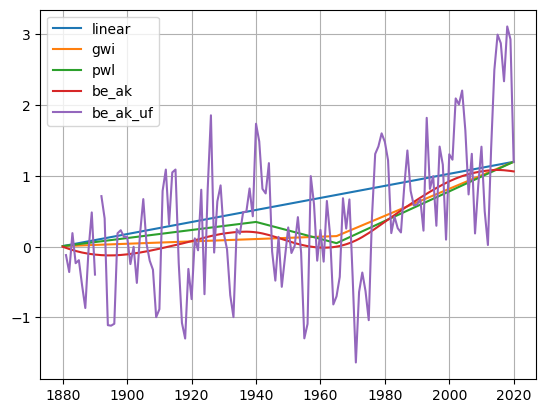

In [3]:
idx = np.arange(1880, 2021, 1)
df = pd.DataFrame([], index=idx)

# linear trend
df['linear'] = np.linspace(0, 1.2, 142)[1:]

# Synthetic GWI
ts1 = np.linspace(df.linear.iloc[0], 0.15, 86)[:-1]
ts2 = np.linspace(0.15, df.linear.iloc[-1], 56)
df['gwi'] = np.concatenate([ts1, ts2])

# follow linear trend at start
ts1 = np.linspace(df.linear.iloc[0], 0.35, 61)[:-1]
ts2 = np.linspace(0.35, 0.05, 26)[:-1]
ts3 = np.linspace(0.05, df.linear.iloc[-1], 56)

df['pwl'] = np.concatenate([ts1, ts2, ts3])

# berk earth AK-avg temp
fp = Path(r'~/src/USGS/glacier_data/berkeley_earth/alaska-TAVG-Trend_clean.csv')
be = pd.read_csv(fp)
be = be.groupby('year').mean()
be = be['annual']
be_uf = be.copy()
be = be.fillna(method='bfill')
sos = sci.signal.butter(2, 1/30, btype='lowpass', output='sos')  # units are half-cycles/sample, so 1/15 = 1 cycle per 30 yrs.
be = pd.Series(sci.signal.sosfiltfilt(sos, be), index=be.index)
be = be.loc[1880:]
be = (be - be.iloc[0])/df['linear'].iloc[-1]
df['be_ak'] = be
df['be_ak_uf'] = be_uf




fig, ax = plt.subplots(1,1)
df.plot(ax=ax)
ax.legend()
ax.grid()

df

# Figure 8

In [5]:

rescol = 'pwl'
melt_factor = -0.65
b_p = df
b_p = b_p * melt_factor

concat = []
for i, (_, g) in tqdm(enumerate(d.iterrows())):
    tau = g['tau']
    params_3s = dict(
        dt=0.01,
        Atot=g['Area'],
        W=g['Area']/g['Lmax'],
        L=g['Lmax'],
        H=g['hf'],
        bt=0,
        b_p=b_p[rescol].values,
        ts=df.index.to_numpy(),
    )
    res = gm.gm3s(tau=tau, **params_3s).run().to_pandas().reset_index()
    res = res.iloc[[-1]]
    res['tau'] = tau
    res['RGIId'] = g['RGIId']
    res['name'] = g['Name']
    res['etcw_feq'] = res.Lp / (res.Lp_eq)
    concat.append(res)
concat = pd.concat(concat, ignore_index=True)
d = d.merge(concat.loc[:, ['RGIId', 'etcw_feq']], on='RGIId')

5608it [00:08, 695.73it/s]


In [12]:
rescol = 'gwi'

melt_factor = -0.65
b_p = df
b_p = b_p * melt_factor

concat = []
for i, (_, g) in tqdm(enumerate(d.iterrows())):
    tau = g['tau']
    params_3s = dict(
        dt=0.01,
        Atot=g['Area'],
        L=g['Lmax'],
        H=g['hf'],
        bt=0,
        b_p=b_p[rescol].values,
        ts=df.index.to_numpy(),
    )
    res = gm.gm3s(tau=tau, **params_3s).run().to_pandas().reset_index()
    res = res.iloc[[-1]]
    res['tau'] = tau
    res['RGIId'] = g['RGIId']
    res['name'] = g['Name']
    res['gwi_eq'] = res.Lp / (res.Lp_eq)

    concat.append(res)
concat = pd.concat(concat, ignore_index=True)
d = d.merge(concat.loc[:, ['RGIId', 'gwi_eq']], on='RGIId')

5608it [00:08, 688.89it/s]


In [7]:
d = d.sort_values(by='RGIId')
rescol = 'linear'
melt_factor = -0.65
b_p = df
b_p = b_p * melt_factor

concat = []
for i, (_, g) in tqdm(enumerate(d.iterrows())):
    tau = g['tau']
    params_3s = dict(
        dt=0.01,
        Atot=g['Area'],
        L=g['Lmax'],
        H=g['hf'],
        bt=0,
        b_p=b_p[rescol].values,
        ts=df.index.to_numpy(),
    )
    res = gm.gm3s(tau=tau, **params_3s).run()
    res = res.to_pandas().reset_index()
    res['tau'] = tau
    res = res.iloc[[-1]]
    res['RGIId'] = g['RGIId']
    res['name'] = g['Name']
    res['linear_feq'] = res.Lp / (res.Lp_eq)
    concat.append(res)
concat = pd.concat(concat, ignore_index=True)
d = d.merge(concat.loc[:, ['RGIId', 'linear_feq']], on='RGIId')

5608it [00:08, 668.69it/s]


In [8]:
d

,feq,tau,bt,hh,hf,RGIId,GLIMSId,BgnDate,EndDate,CenLon,...,l_above,l_below,sum,aalr,slope_above,slope_below,Zela_idx,etcw_feq,gwi,linear_feq
0,0.650370,28.364015,-1.354167,76.278305,38.409604,RGI60-01.00003,G213920E63376N,20090703,-9999999,-146.080000,...,1344.461334,615.828902,1960.290236,0.685848,0.300743,0.276833,24,0.341588,0.348243,0.655164
1,0.783453,17.503974,-4.090860,72.452052,71.606299,RGI60-01.00004,G213880E63381N,20090703,-9999999,-146.120000,...,1554.328005,2441.859814,3996.187819,0.388953,0.232039,0.291871,21,0.506047,0.538629,0.786497
2,0.741926,20.865693,-2.523997,77.168012,52.664936,RGI60-01.00005,G212943E63551N,20090703,-9999999,-147.057000,...,1664.330736,1408.045545,3072.376280,0.541708,0.247643,0.273559,26,0.441411,0.468888,0.745546
3,0.225196,80.565408,-2.828861,64.692365,227.908362,RGI60-01.00006,G213756E63571N,20090703,-9999999,-146.244000,...,5719.413695,4839.536301,10558.949996,0.541665,0.082260,0.328114,52,0.112717,0.076646,0.230199
4,0.432573,48.694751,-1.417976,59.657545,69.047968,RGI60-01.00009,G212400E63659N,20090703,-9999999,-147.600000,...,1512.183693,863.969952,2376.153645,0.636400,0.227483,0.356990,28,0.209511,0.175308,0.438793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5603,0.129088,111.061559,-4.558791,187.124423,506.306487,RGI60-01.27105,G227608E57164N,20040810,-9999999,-132.392000,...,15047.893888,18466.187491,33514.081378,0.449002,0.034806,0.111643,44,0.066647,0.041033,0.132539
5604,0.752364,20.019871,-2.970659,61.425298,59.472206,RGI60-01.27106,G220930E60344N,20100814,-9999999,-139.070000,...,1452.263829,990.113438,2442.377267,0.594611,0.400331,0.346278,22,0.456306,0.485465,0.755840
5605,0.047520,179.310275,-2.105694,440.430560,377.572520,RGI60-01.27108,G216273E60232N,20100910,-9999999,-143.726807,...,61998.972947,15596.509812,77595.482759,0.799002,0.019040,0.047352,155,0.025494,0.014206,0.049046
5606,0.783751,17.479871,-3.332243,103.484520,58.247171,RGI60-01.27110,G230488E54596N,20049999,20069999,-129.512000,...,1512.103054,2159.898165,3672.001219,0.411793,0.214263,0.202845,21,0.506564,0.539166,0.786791


38
38
38 38
38
38
38 38
38
38
38 38
38
38
38 38
41
41
41 41
41
41
41 41
41
41
41 41
41
41
41 41
39
39
39 39
39
39
39 39
39
39
39 39
39
39
39 39
0.34116897577993494
0.3477001481863816
0.6546778460186589
[0.33883338]
[0.1626912]
[0.1231818]
[Text(0, -0.5, ''), Text(0, 0.0, '0.0'), Text(0, 0.5, '0.5'), Text(0, 1.0, '1.0'), Text(0, 1.5, '1.5'), Text(0, 2.0, '2.0')]
[Text(0, 0.0, ''), Text(0, 0.2, '0.2'), Text(0, 0.4, '0.4'), Text(0, 0.6000000000000001, '0.6'), Text(0, 0.8, '0.8'), Text(0, 1.0, '1.0')]
[Text(0, 0.0, ''), Text(0, 0.2, '0.2'), Text(0, 0.4, '0.4'), Text(0, 0.6000000000000001, '0.6'), Text(0, 0.8, '0.8'), Text(0, 1.0, '1.0')]


/var/folders/bb/wssqxcxj4tgg0s9fdw74731m0000gn/T/ipykernel_47177/2778757697.py:119: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.3, hspace=0.075)
/var/folders/bb/wssqxcxj4tgg0s9fdw74731m0000gn/T/ipykernel_47177/2778757697.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/bb/wssqxcxj4tgg0s9fdw74731m0000gn/T/ipykernel_47177/2778757697.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(labels)


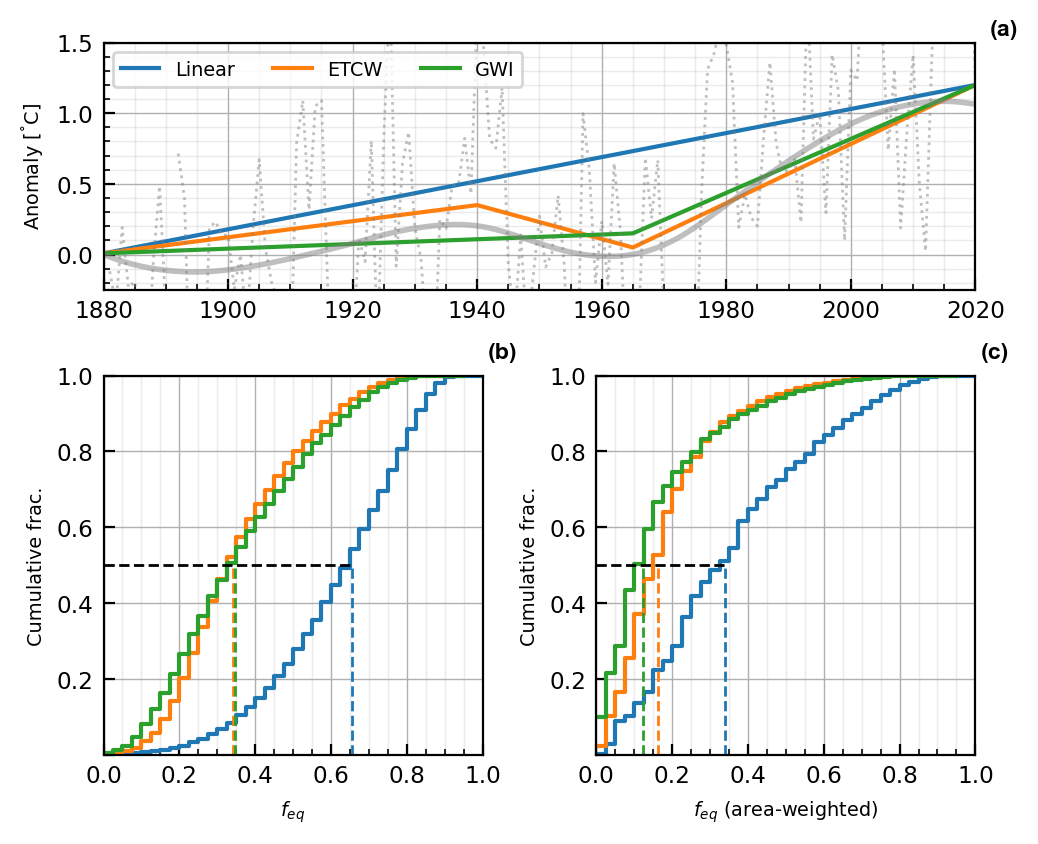

In [13]:
binfreq = 0.025
x = d.dropna(subset='etcw_feq')['etcw_feq']
area = d.dropna(subset='etcw_feq')['Area']
nleq_uwpdf, nleq_bins = hist2(x, binfreq=binfreq, from_zero=True)
nleq_awpdf, nleq_bins = hist2(x, area=area, binfreq=binfreq, from_zero=True)
nleq_uwcdf, nleq_bins = hist2(x, binfreq=binfreq, cumsum=True, from_zero=True)
nleq_awcdf, nleq_bins = hist2(x, area=area, binfreq=binfreq, cumsum=True, from_zero=True)

x = d.dropna(subset='linear_feq')['linear_feq']
area = d.dropna(subset='linear_feq')['Area']
eq_uwpdf, eq_bins = hist2(x, binfreq=binfreq, from_zero=True)
eq_awpdf, eq_bins = hist2(x, area=area, binfreq=binfreq, from_zero=True)
eq_uwcdf, eq_bins = hist2(x, binfreq=binfreq, cumsum=True, from_zero=True)
eq_awcdf, eq_bins = hist2(x, area=area, binfreq=binfreq, cumsum=True, from_zero=True)

x = d.dropna(subset='gwi_eq')['gwi_eq']
area = d.dropna(subset='gwi_eq')['Area']
gwi_uwpdf, gwi_bins = hist2(x, binfreq=binfreq, from_zero=True)
gwi_awpdf, gwi_bins = hist2(x, area=area, binfreq=binfreq, from_zero=True)
gwi_uwcdf, gwi_bins = hist2(x, binfreq=binfreq, cumsum=True, from_zero=True)
gwi_awcdf, gwi_bins = hist2(x, area=area, binfreq=binfreq, cumsum=True, from_zero=True)


fig = plt.figure(figsize=(4.5*1.25, 4*1.25), dpi=200, layout='constrained')
gs = mpl.gridspec.GridSpec(2, 2, height_ratios=[1, 2])
ax = [
    fig.add_subplot(gs[0, :]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1]),
]

ax[0].plot(df.linear, label='Linear')
ax[0].plot(df.pwl, label='ETCW')
ax[0].plot(df.gwi, label='GWI')
ax[0].plot(df['be_ak'], color='grey', alpha=0.5, lw=2)
ax[0].plot(df['be_ak_uf'], color='grey', alpha=0.5, lw=1, ls=':')

ax[1].step(eq_bins, eq_uwcdf)
ax[1].step(nleq_bins, nleq_uwcdf)
ax[1].step(gwi_bins, gwi_uwcdf)

ax[2].step(eq_bins, eq_awcdf)
ax[2].step(nleq_bins, nleq_awcdf)
ax[2].step(gwi_bins, gwi_awcdf)

# median lines

xmax = np.median(d['etcw_feq'].dropna())
print(xmax)
ax[1].plot([xmax, xmax], [0, 0.5],  ls='--', c='tab:orange', lw=1, alpha=1)

xmax = np.median(d['gwi_eq'].dropna())
print(xmax)
ax[1].plot([xmax, xmax], [0, 0.5], ls='--', c='tab:green', lw=1, alpha=1)

xmax = np.median(d['linear_feq'].dropna())
print(xmax)
ax[1].plot([xmax, xmax], [0, 0.5],  ls='--', c='tab:blue', lw=1, alpha=1)
ax[1].plot([0, xmax], [0.5, 0.5], ls='--', c='black', lw=1)


area = d['Area'].to_numpy()
x = weighted_quantile(d['linear_feq'].to_numpy(), [0.5], sample_weight=area)
print(x)
ax[2].plot([0, x[0]], [0.5, 0.5], ls='--', c='black', lw=1)
ax[2].plot([x,x], [0, 0.5], ls='--', c='tab:blue', lw=1)

x = weighted_quantile(d['etcw_feq'].to_numpy(), [0.5], sample_weight=area)
print(x)
ax[2].plot([x,x], [0, 0.5], ls='--', c='tab:orange', lw=1)

x = weighted_quantile(d['gwi_eq'].to_numpy(), [0.5], sample_weight=area)
print(x)
ax[2].plot([x,x], [0, 0.5], ls='--', c='tab:green', lw=1)


#ax[2].plot([0.5, 0.5], [0, nleq_awcdf[idxmed]], ls='-', c='black', lw=1.5)

ax[0].legend(fontsize='x-small', ncol=3)
for axis in ax:
    axis.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
    axis.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
    axis.grid(which='major', axis='both', alpha=1, lw=0.5)
    axis.grid(which='minor', axis='both', alpha=0.25, lw=0.5)
    axis.set_axisbelow(True)    
    axis.tick_params(axis="both", which='both', direction="in", left="off", labelleft="on", length=2, labelsize='small')
    axis.tick_params(axis='both', which='major', length=4, labelsize='small')
    axis.set_ylim([0, 1.00])
    axis.set_xlim(0, 1)
ax[1].set_box_aspect(1)
ax[2].set_box_aspect(1)
ax[0].set_ylim(-0.25, 1.5)
ax[0].set_xlim(1880, 2020)
#ax[0].set_xlabel('Year', fontsize='x-small')
ax[1].set_xlabel(r'$f_{eq}$', fontsize='x-small')
ax[2].set_xlabel(r'$f_{eq}$ (area-weighted)', fontsize='x-small')
ax[0].set_ylabel('Anomaly [$^\degree$C]', fontsize='x-small')
ax[1].set_ylabel('Cumulative frac.', fontsize='x-small')
ax[2].set_ylabel('Cumulative frac.', fontsize='x-small')
ax[0].xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
ax[0].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax[0].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
# #ax[0].set_xticks(np.arange(0, 1, 0.2))
# ax[1].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
# ax[1].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

# label subplots
sp_labels = ['(' + letter + ')' for letter in string.ascii_lowercase]
for i, axis in enumerate(ax[1:]):
    # label physical distance in and down:
    trans = mpl.transforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    #axis.text(0.975, 1.2, sp_labels[i], transform=axis.transAxes + trans,
    axis.text(0.94, 1.125, sp_labels[i+1], transform=axis.transAxes + trans,
              verticalalignment='top', fontsize='small', font='Arial', fontweight='bold')
ax[0].text(0.985, 1.15, sp_labels[0], transform=ax[0].transAxes + trans,
          verticalalignment='top', fontsize='small', font='Arial', fontweight='bold')

plt.subplots_adjust(wspace=0.3, hspace=0.075)

# Important to render initial ytick labels
fig.show()
fig.canvas.draw()

# remove bottom ylabel
for axis in ax:
    labels = [item for item in axis.get_yticklabels()]
    labels[0].set_text('')
    print(labels)
    axis.set_yticklabels(labels)

fig.set_size_inches(4.5*1.25, 4*1.25)
plt.savefig(Path('diseq_shapes.png'))

# Figure 9

In [23]:
# linear diseq
# disequilibrium 3-stage
def calc_diseq(tau):
    eps = 1 / np.sqrt(3)
    t = 140
    frac_eq = 1 - 3 * eps * tau / t * (1 - np.exp(-t / (eps * tau))) + np.exp(-t / (eps * tau)) * (
                t / (2 * eps * tau) + 2)
    return frac_eq


rescol = 'pwl'
melt_factor = -0.65
b_p = df * melt_factor

taus = list(np.arange(1, 500, 1))
concat = []
params_3s = dict(
    Atot=8000,
    W=1,
    L=8000,
    H=100,
    bt=0,
    b_p=b_p[rescol].to_numpy(),
    ts=df.index.to_numpy(),
)
for tau in tqdm(taus):
    res = gm.gm3s(tau=tau, **params_3s).run().to_pandas().reset_index()
    res['tau'] = tau
    concat.append(res)
curve = pd.concat(concat, ignore_index=True)
curve = curve.loc[curve.t == 2020, :]


rescol = 'gwi'
melt_factor = -0.65
b_p = df * melt_factor
taus = list(np.arange(1, 500, 1))
concat = []
params_3s = dict(
    Atot=8000,
    W=1,
    L=8000,
    H=100,
    bt=0,
    b_p=b_p[rescol].to_numpy(),
    ts=df.index.to_numpy(),
)
for tau in tqdm(taus):
    res = gm.gm3s(tau=tau, **params_3s).run().to_pandas().reset_index()
    res['tau'] = tau
    concat.append(res)
gwi_curve = pd.concat(concat, ignore_index=True)
gwi_curve = gwi_curve.loc[gwi_curve.t == 2020, :]


rescol = 'linear'
melt_factor = -0.65
b_p = df * melt_factor
taus = list(np.arange(1, 500, 1))
concat = []
params_3s = dict(
    Atot=8000,
    W=1,
    L=8000,
    H=100,
    bt=0,
    b_p=b_p[rescol].to_numpy(),
    ts=df.index.to_numpy(),
)
for tau in tqdm(taus):
    res = gm.gm3s(tau=tau, **params_3s).run().to_pandas().reset_index()
    res['tau'] = tau
    concat.append(res)
linear_curve = pd.concat(concat, ignore_index=True)
linear_curve = linear_curve.loc[linear_curve.t == 2020, :]

curve['etcw_feq'] = curve.Lp / (curve.Lp_eq)
curve['linear_feq'] = linear_curve.Lp / (linear_curve.Lp_eq)
curve['gwi_feq'] = gwi_curve.Lp / (gwi_curve.Lp_eq)
curve = curve.reset_index(drop=True)

curve

100%|██████████| 499/499 [00:00<00:00, 1195.52it/s]


,t,Lp,Lp_eq,dL,L,bt_p,L_bar,tau,etcw_feq,linear_feq,gwi_feq
0,2020.0,-60.516506,-62.4,62.4,7939.483494,-0.78,8000,1,0.969816,0.987716,0.972442
1,2020.0,-117.267154,-124.8,124.8,7882.732846,-0.78,8000,2,0.939641,0.975432,0.944889
2,2020.0,-170.251096,-187.2,187.2,7829.748904,-0.78,8000,3,0.909461,0.963148,0.917334
3,2020.0,-219.468614,-249.6,249.6,7780.531386,-0.78,8000,4,0.879281,0.950864,0.889779
4,2020.0,-264.919711,-312.0,312.0,7735.080289,-0.78,8000,5,0.849102,0.938580,0.862223
...,...,...,...,...,...,...,...,...,...,...,...
494,2020.0,-60.355511,-30888.0,30888.0,7939.644489,-0.78,8000,495,0.001954,0.003611,0.000974
495,2020.0,-60.148929,-30950.4,30950.4,7939.851071,-0.78,8000,496,0.001943,0.003591,0.000968
496,2020.0,-59.943397,-31012.8,31012.8,7940.056603,-0.78,8000,497,0.001933,0.003572,0.000963
497,2020.0,-59.738908,-31075.2,31075.2,7940.261092,-0.78,8000,498,0.001922,0.003552,0.000958


56
18
23


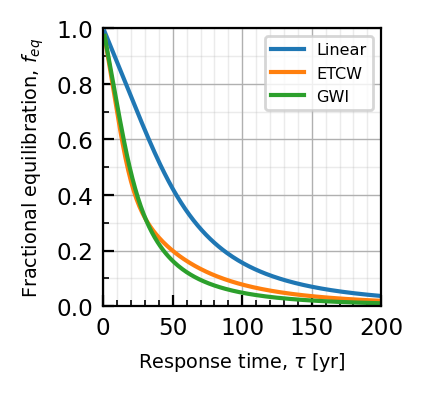

In [24]:
fig, ax = plt.subplots(1,1, layout='constrained', figsize=(2.25, 2.25), dpi=200)

tau = curve['tau'].to_numpy()
lower_tau = (curve['tau']/2).to_numpy()
upper_tau = (3 * curve['tau']/2).to_numpy()

feq = curve['linear_feq'].to_numpy()
lower_linear = np.interp(lower_tau, tau, feq)
upper_linear = np.interp(upper_tau, tau, feq)
# lower_linear = np.take(feq, lower_tau, mode='clip')
# upper_linear = np.take(feq, upper_tau, mode='clip')

feq = curve['etcw_feq'].to_numpy()
lower_nonlinear = np.interp(lower_tau, tau, feq)
upper_nonlinear = np.interp(upper_tau, tau, feq)

feq = curve['gwi_feq'].to_numpy()
lower_gwi = np.interp(lower_tau, tau, feq)
upper_gwi = np.interp(upper_tau, tau, feq)

print(np.argmax(lower_linear - upper_linear))
print(np.argmax(lower_nonlinear - upper_nonlinear))
print(np.argmax(lower_gwi - upper_gwi))

#ax.fill_between(tau, lower_linear, upper_linear, fc='tab:blue', alpha=0.1, ec='none', lw=0)
#ax.plot(tau, lower_linear, c='tab:blue', alpha=0.1)
#ax.plot(tau, upper_linear, c='tab:blue', alpha=0.1)

#ax.fill_between(tau, lower_nonlinear, upper_nonlinear, fc='tab:orange', alpha=0.1, ec='none', lw=0)
#ax.plot(tau, lower_nonlinear, c='tab:orange', alpha=0.1)
#ax.plot(tau, upper_nonlinear, c='tab:orange', alpha=0.1)

#ax.fill_between(tau, lower_gwi, upper_gwi, fc='tab:green', alpha=0.1, ec='none', lw=0)
#ax.plot(tau, lower_gwi, c='tab:green', alpha=0.1)
#ax.plot(tau, upper_gwi, c='tab:green', alpha=0.1)

ax.plot(curve.tau, curve.linear_feq, label='Linear')
ax.plot(curve.tau, curve.etcw_feq, label='ETCW')
ax.plot(curve.tau, curve.gwi_feq, label='GWI')
ax.set_xlabel(r'Response time, $\tau$ [$\mathregular{yr}$]', fontsize='x-small')
ax.set_ylabel(r'Fractional equilibration, $f_{eq}$', fontsize='x-small')
ax.set_box_aspect(1)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(50))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.grid(which='major', axis='both', alpha=1, lw=0.5)
ax.grid(which='minor', axis='both', alpha=0.25, lw=0.5)
ax.set_xlim(0, 200)
ax.set_ylim(0, 1)
ax.set_axisbelow(True)    
ax.tick_params(axis="both", which='both', direction="in", left="off", labelleft="on", length=2, labelsize='small')
ax.tick_params(axis='both', which='major', length=4)
ax.legend(fontsize='xx-small')

fig.set_size_inches(2, 2)
plt.savefig(Path('Fig9.png'))